In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

import pandas as pd

from  sklearn.metrics import mean_squared_error as MSE

import VReceptor

In [2]:
prrp_data=pd.read_csv('./PrRP_data.csv')

prrp_data=prrp_data.dropna()
prrp_data=prrp_data[~prrp_data['Sequence'].str.contains('X')]

print (len(prrp_data))
prrp_data=prrp_data[prrp_data['rel_logGPR10']<1.9]
print (len(prrp_data))

#removing all duplicates
prrp_data = prrp_data.groupby('Sequence').agg({
    'ID': 'first',
    'Experimental Round': 'first',
    'logGPR10': 'mean',
    'logNPFFR1': 'mean',
    'logNPFFR2': 'mean',
    'rel_logGPR10': 'mean',
    'rel_logNPFFR1': 'mean',
    'rel_logNPFFR2': 'mean',}).reset_index()





len(prrp_data)


639
639


500

In [3]:
ref = 'SRTHRHSMEIRTPDINPAWYASRGIRPVGRF'
sim = {'cosine' : VReceptor.cosine_dist, 'chebyshev' : VReceptor.chebyshev_dist, 'L2_sim' : VReceptor.L2_dist}
y_train_pred = {}
y_test_pred = {}
y_label = ['rel_logGPR10']
for key, item in sim.items():
    def func_wrapper(parameter,  *args):
        seq_list=args[0]
        results=args[1]
        para=[2,0]
        for i in parameter:
            para.append(i)
        receptor=VReceptor.vreceptor(ref, *para, func=VReceptor.func, aa_norm = item)
        pred=np.array(list(receptor.virtual_assay(seq_list, noise=0.0)['logIC50']))
        results=np.array(results)
        pr,_ = scipy.stats.pearsonr(pred,results)
        return MSE(pred,results)

    for y_test_label in y_label:
        data_new = prrp_data[prrp_data[y_test_label] < 2.0]
        X = list(data_new['Sequence'])
        y = list(data_new[y_test_label])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42)
        mini = 1000
        
        for i in range (32,0,-4):
            for j in range (32,i,-4):
                init_para = [i,1,1,j,1,1]
                opt_1 = minimize(func_wrapper,init_para,args = (X_train,y_train))
                if opt_1.fun < mini:
                    mini = opt_1.fun
                    opt = opt_1
                print (f'MSE = {mini:.2f}\tStart: {i} {j}\tFound: {opt.x[0]:.1f} {opt.x[3]:.1f}')
        para_1=[2,0]
        for i in opt.x:
            para_1.append(i)
        print (para_1)
        model_min = VReceptor.vreceptor(ref, *para_1, func = VReceptor.func, aa_norm = item)
        data_min_train = model_min.virtual_assay(X_train, noise = 0.0)
        data_min_test = model_min.virtual_assay(X_test, noise = 0.0)
        
        y_train_pred[key] = data_min_train['logIC50'].values
        y_test_pred[key] = data_min_test['logIC50'].values

MSE = 0.14	Start: 28 32	Found: 28.7 30.1
MSE = 0.13	Start: 24 32	Found: 26.0 56.0
MSE = 0.13	Start: 24 28	Found: 26.0 56.0
MSE = 0.13	Start: 20 32	Found: 26.0 56.0
MSE = 0.13	Start: 20 28	Found: 26.0 56.0
MSE = 0.13	Start: 20 24	Found: 26.0 56.0
MSE = 0.13	Start: 16 32	Found: 26.0 56.0
MSE = 0.13	Start: 16 28	Found: 26.0 56.0
MSE = 0.13	Start: 16 24	Found: 26.0 56.0
MSE = 0.13	Start: 16 20	Found: 26.0 56.0
MSE = 0.13	Start: 12 32	Found: 26.0 56.0
MSE = 0.13	Start: 12 28	Found: 26.0 56.0
MSE = 0.13	Start: 12 24	Found: 26.0 56.0
MSE = 0.13	Start: 12 20	Found: 8.2 68.4
MSE = 0.13	Start: 12 16	Found: 8.2 68.4
MSE = 0.13	Start: 8 32	Found: 8.2 74.0
MSE = 0.13	Start: 8 28	Found: 8.2 74.0
MSE = 0.13	Start: 8 24	Found: 8.2 74.0
MSE = 0.13	Start: 8 20	Found: 8.2 74.0
MSE = 0.13	Start: 8 16	Found: 8.2 74.0
MSE = 0.13	Start: 8 12	Found: 8.2 74.0
MSE = 0.13	Start: 4 32	Found: 8.2 74.0
MSE = 0.13	Start: 4 28	Found: 8.2 74.0
MSE = 0.13	Start: 4 24	Found: 8.2 74.0
MSE = 0.13	Start: 4 20	Found: 8.2 74

cosine: Train: Pearson r=0.82, Spearman r=0.80, MSE=0.131 Test:  Pearson r=0.77, Spearman r=0.75, MSE=0.155
chebyshev: Train: Pearson r=0.85, Spearman r=0.83, MSE=0.109 Test:  Pearson r=0.83, Spearman r=0.80, MSE=0.118
L2_sim: Train: Pearson r=0.85, Spearman r=0.83, MSE=0.108 Test:  Pearson r=0.83, Spearman r=0.80, MSE=0.118


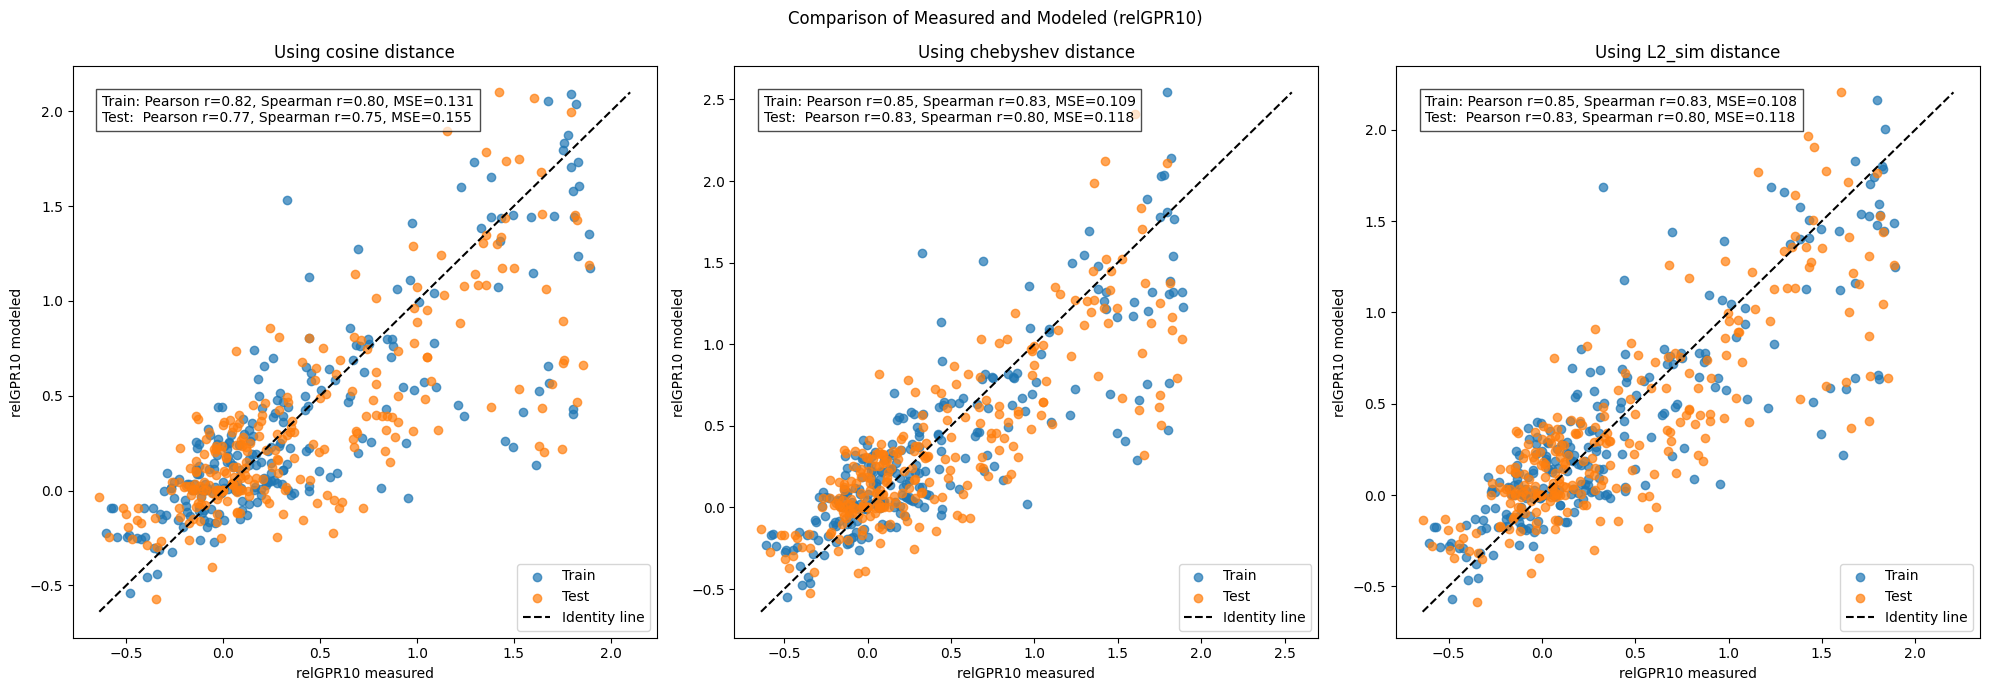

In [4]:
y_test_label = 'relGPR10'
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for n, key in enumerate(sim.keys()):
    axes[n].scatter(y_train, y_train_pred[key], alpha=0.7, label='Train')
    axes[n].scatter(y_test, y_test_pred[key], alpha=0.7, label='Test')
    
    # Plot identity line
    all_vals = np.concatenate([y_train, y_test, y_train_pred[key], y_test_pred[key]])
    lims = [all_vals.min(), all_vals.max()]
    axes[n].plot(lims, lims, 'k--', label='Identity line')
    
    axes[n].set_xlabel(f'{y_test_label} measured')
    axes[n].set_ylabel(f'{y_test_label} modeled')
    axes[n].set_title(f'Using {key} distance')
    axes[n].legend()
    
    
    # Calculate statistics for train
    pearson_r_train, pearson_p_train = scipy.stats.pearsonr(y_train, y_train_pred[key])
    spearman_r_train, spearman_p_train = scipy.stats.spearmanr(y_train, y_train_pred[key])
    mse_train = MSE(y_train, y_train_pred[key])
    
    # Calculate statistics for test
    pearson_r_test, pearson_p_test = scipy.stats.pearsonr(y_test, y_test_pred[key])
    spearman_r_test, spearman_p_test = scipy.stats.spearmanr(y_test, y_test_pred[key])
    mse_test = MSE(y_test, y_test_pred[key])
    
    # Annotate statistics on the plot
    axes[n].text(0.05, 0.95,
             f'Train: Pearson r={pearson_r_train:.2f}, Spearman r={spearman_r_train:.2f}, MSE={mse_train:.3f}\n'
             f'Test:  Pearson r={pearson_r_test:.2f}, Spearman r={spearman_r_test:.2f}, MSE={mse_test:.3f}',
             transform=axes[n].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    print (f'{key}: Train: Pearson r={pearson_r_train:.2f}, Spearman r={spearman_r_train:.2f}, MSE={mse_train:.3f} Test:  Pearson r={pearson_r_test:.2f}, Spearman r={spearman_r_test:.2f}, MSE={mse_test:.3f}')
fig.suptitle(f'Comparison of Measured and Modeled ({y_test_label})')
plt.tight_layout()
plt.savefig(f'Combine_{y_test_label}.jpg')
plt.show()

# 